In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'C:/dhs_zm/ZMBR71DT_birth recode/ZMBR71FL.DTA'
df = pd.read_stata(file_path, convert_categoricals=False)

# Select important columns for mortality analysis
# b5: Child is alive (1 = Yes, 0 = No)
# b7: Age at death (in months, if deceased)
# v008: Century month code of interview
# v005: Sample weight (divide by 1,000,000 for analysis)
df = df[['b5', 'b7', 'b8', 'v008', 'v005', 'v106', 'v025', 'v190', 'v101', 'v113', 'm70', 'b12']]

# Sample weight normalization
df['weight'] = df['v005'] / 1_000_000

# Add derived columns for clarity
# Calculate age at death in days for neonatal analysis (approximation: 1 month = 30.4375 days)
df['age_at_death_days'] = np.where(df['b5'] == 0, df['b7'] * 30.4375, np.nan)

# Create binary features
df['postnatal_check_done'] = np.where(df['m70'] == 1, 1, 0)  # Postnatal care indicator

# Create socioeconomic index (combining wealth, education, and residence)
df['socioeconomic_index'] = df['v190'] + (df['v106'] * 0.5) + (df['v025'] * 0.3)

# Create health access index
df['health_access_index'] = ((df['v113'] == 11) | (df['v113'] == 12)).astype(int) + df['postnatal_check_done']

# Interaction features
df['wealth_residence_interaction'] = df['v190'] * df['v025']

# Filter live births
live_births = df[df['b5'] == 1]

# Neonatal Mortality: Deaths within the first month (0-30 days)
neonatal_deaths = df[(df['b5'] == 0) & (df['age_at_death_days'] <= 30)]

# Postneonatal Mortality: Deaths between 1 and 11 months
postneonatal_deaths = df[(df['b5'] == 0) & (df['age_at_death_days'] > 30) & (df['b7'] < 12)]

# Infant Mortality: Deaths within the first year (0-11 months)
infant_deaths = df[(df['b5'] == 0) & (df['b7'] < 12)]

# Child Mortality: Deaths between 12 and 59 months
child_deaths = df[(df['b5'] == 0) & (df['b7'] >= 12) & (df['b7'] < 60)]

# Under-Five Mortality: Deaths within the first five years (0-59 months)
under_five_deaths = df[(df['b5'] == 0) & (df['b7'] < 60)]

# Calculate mortality rates
# Denominators and numerators use weights
total_live_births = live_births['weight'].sum()

neonatal_rate = (neonatal_deaths['weight'].sum() / total_live_births) * 1000
postneonatal_rate = (postneonatal_deaths['weight'].sum() / total_live_births) * 1000
infant_rate = (infant_deaths['weight'].sum() / total_live_births) * 1000

# For child mortality, denominator is children surviving to 12 months
children_surviving_to_12_months = total_live_births - infant_deaths['weight'].sum()
child_rate = (child_deaths['weight'].sum() / children_surviving_to_12_months) * 1000

under_five_rate = (under_five_deaths['weight'].sum() / total_live_births) * 1000

# Display results
print(f"Neonatal Mortality Rate (NN): {neonatal_rate:.2f} deaths per 1,000 live births")
print(f"Postneonatal Mortality Rate (PNN): {postneonatal_rate:.2f} deaths per 1,000 live births")
print(f"Infant Mortality Rate (IMR): {infant_rate:.2f} deaths per 1,000 live births")
print(f"Child Mortality Rate (CM): {child_rate:.2f} deaths per 1,000 children surviving to 12 months")
print(f"Under-Five Mortality Rate (U5MR): {under_five_rate:.2f} deaths per 1,000 live births")


Neonatal Mortality Rate (NN): 27.32 deaths per 1,000 live births
Postneonatal Mortality Rate (PNN): 28.82 deaths per 1,000 live births
Infant Mortality Rate (IMR): 56.14 deaths per 1,000 live births
Child Mortality Rate (CM): 33.98 deaths per 1,000 children surviving to 12 months
Under-Five Mortality Rate (U5MR): 88.22 deaths per 1,000 live births


In [20]:
# Extracting feature columns
feature_columns = ['b5', 'b7', 'b8', 'b12', 'm70', 'v005', 'v106', 'v025', 'v190', 'v101', 'v113']

# Check headers and statistics for the selected columns
df_headers = df[feature_columns].head()
df_describe = df[feature_columns].describe()

print(df_headers, df_describe)

   b5   b7    b8   b12  m70     v005  v106  v025  v190  v101  v113
0   1  NaN   0.0   NaN  0.0  1892890     0     2     1     3    21
1   1  NaN   6.0  61.0  NaN  1892890     0     2     1     3    21
2   1  NaN   8.0  24.0  NaN  1892890     0     2     1     3    21
3   1  NaN  11.0  35.0  NaN  1892890     0     2     1     3    21
4   0  2.0   NaN  12.0  NaN  1892890     0     2     1     3    21                  b5           b7            b8           b12          m70  \
count  38446.000000  3495.000000  34951.000000  27948.000000  7372.000000   
mean       0.909093    22.993133     10.156190     37.489659     0.623304   
std        0.287480    45.009659      7.370261     20.325346     0.500023   
min        0.000000     0.000000      0.000000      8.000000     0.000000   
25%        1.000000     0.000000      4.000000     25.000000     0.000000   
50%        1.000000     8.000000      9.000000     33.000000     1.000000   
75%        1.000000    24.000000     15.000000     44.00000

Correlations with IMR_target:
IMR_target               1.000000
U5MR_target              0.785179
v113                     0.015593
v025                     0.002966
v005                    -0.002900
v101                    -0.005679
v190                    -0.022382
v106                    -0.029129
ChildMortality_target   -0.040626
b12                     -0.119453
m70                     -0.127203
b7                      -0.514506
b5                      -0.737269
b8                            NaN
Name: IMR_target, dtype: float64

Correlations with ChildMortality_target:
ChildMortality_target    1.000000
U5MR_target              0.586859
v113                     0.026527
b7                       0.015563
v025                     0.004642
v005                    -0.002301
m70                     -0.019006
v101                    -0.023266
v190                    -0.026477
IMR_target              -0.040626
b12                     -0.044005
v106                    -0.047257
b5         

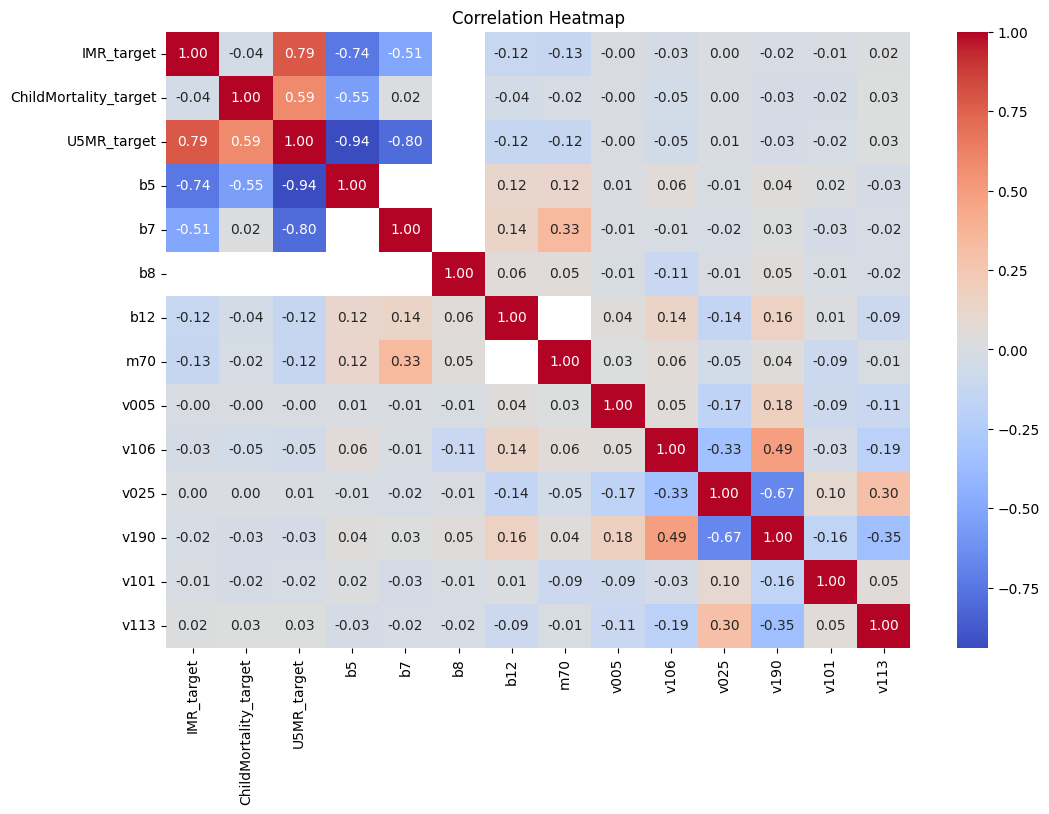

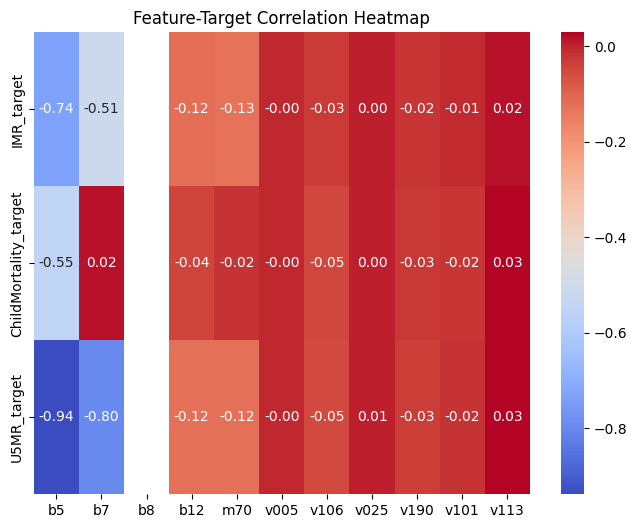

In [21]:
# Import necessary libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Create target variables
df['IMR_target'] = np.where((df['b5'] == 0) & (df['b7'] < 12), 1, 0)
df['ChildMortality_target'] = np.where((df['b5'] == 0) & (df['b7'] >= 12) & (df['b7'] < 60), 1, 0)
df['U5MR_target'] = np.where((df['b5'] == 0) & (df['b7'] < 60), 1, 0)

# Select features and target variables for correlation
correlation_columns = ['IMR_target', 'ChildMortality_target', 'U5MR_target'] + feature_columns

# Compute correlation matrix
correlation_matrix = df[correlation_columns].corr()

# Display correlations of features against the target variables
print("Correlations with IMR_target:")
print(correlation_matrix['IMR_target'].sort_values(ascending=False))

print("\nCorrelations with ChildMortality_target:")
print(correlation_matrix['ChildMortality_target'].sort_values(ascending=False))

print("\nCorrelations with U5MR_target:")
print(correlation_matrix['U5MR_target'].sort_values(ascending=False))

# Plot heatmap for the entire correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Plot heatmap for correlations only between features and target variables
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix.loc[correlation_columns[:3], feature_columns], annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature-Target Correlation Heatmap")
plt.show()



Random Forest Metrics for Under-Five Mortality (Balanced Data):
Accuracy: 0.59
Precision: 0.56
Recall: 0.62
F1-Score: 0.59
AUC-ROC: 0.65


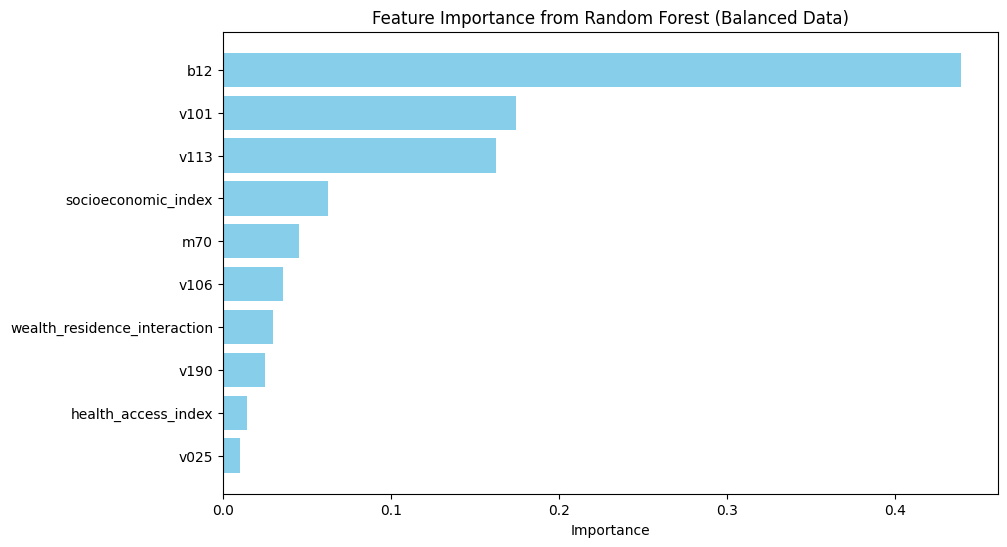

In [24]:
from sklearn.utils import resample

# ---------------- Data Preprocessing ----------------
# Separate majority and minority classes for under-five mortality
X['target'] = y_u5mr  # Temporarily add target column for resampling
majority = X[X['target'] == 0]  # Majority class (survived)
minority = X[X['target'] == 1]  # Minority class (died)

# Under-sample the majority class
majority_downsampled = resample(
    majority, 
    replace=False,  # No replacement
    n_samples=len(minority),  # Match minority class size
    random_state=42  # Reproducibility
)

# Combine minority and downsampled majority class
balanced_data = pd.concat([majority_downsampled, minority])

# Split balanced data into features and target
X_balanced = balanced_data.drop(columns=['target'])
y_balanced = balanced_data['target']

# Update train-test split with balanced data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, 
    y_balanced, 
    test_size=0.2, 
    random_state=42
)

# ---------------- Random Forest with Balanced Data ----------------
# Train a Random Forest Classifier on the balanced dataset
rf_classifier_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_balanced.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_balanced_pred = rf_classifier_balanced.predict(X_test_balanced)
y_balanced_pred_prob = rf_classifier_balanced.predict_proba(X_test_balanced)[:, 1]

# Evaluate Random Forest
print("\nRandom Forest Metrics for Under-Five Mortality (Balanced Data):")
print(f"Accuracy: {accuracy_score(y_test_balanced, y_balanced_pred):.2f}")
print(f"Precision: {precision_score(y_test_balanced, y_balanced_pred):.2f}")
print(f"Recall: {recall_score(y_test_balanced, y_balanced_pred):.2f}")
print(f"F1-Score: {f1_score(y_test_balanced, y_balanced_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test_balanced, y_balanced_pred_prob):.2f}")

# ---------------- Feature Importance ----------------
# Extract feature importance
feature_importance_balanced = rf_classifier_balanced.feature_importances_
importance_df_balanced = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importance_balanced}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df_balanced['Feature'], importance_df_balanced['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance from Random Forest (Balanced Data)")
plt.gca().invert_yaxis()
plt.show()



Random Forest Metrics for Infant Mortality (Balanced Data):
Accuracy: 0.61
Precision: 0.60
Recall: 0.60
F1-Score: 0.60
AUC-ROC: 0.65


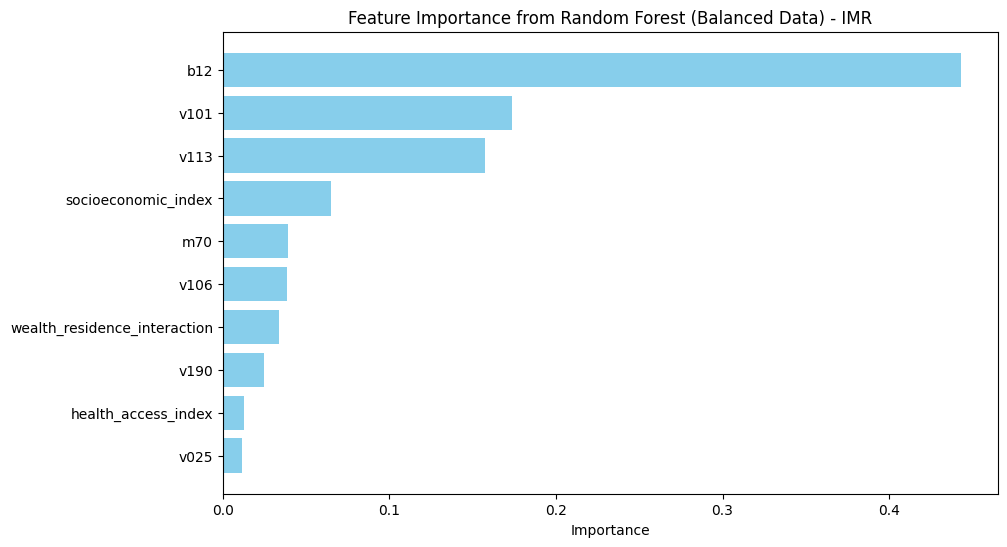

In [25]:
from sklearn.utils import resample

# ---------------- Data Preprocessing ----------------
# Separate majority and minority classes for infant mortality
X['target'] = y_imr  # Temporarily add target column for resampling
majority_imr = X[X['target'] == 0]  # Majority class (survived)
minority_imr = X[X['target'] == 1]  # Minority class (died)

# Under-sample the majority class
majority_downsampled_imr = resample(
    majority_imr, 
    replace=False,  # No replacement
    n_samples=len(minority_imr),  # Match minority class size
    random_state=42  # Reproducibility
)

# Combine minority and downsampled majority class
balanced_data_imr = pd.concat([majority_downsampled_imr, minority_imr])

# Split balanced data into features and target
X_balanced_imr = balanced_data_imr.drop(columns=['target'])
y_balanced_imr = balanced_data_imr['target']

# Update train-test split with balanced data
X_train_balanced_imr, X_test_balanced_imr, y_train_balanced_imr, y_test_balanced_imr = train_test_split(
    X_balanced_imr, 
    y_balanced_imr, 
    test_size=0.2, 
    random_state=42
)

# ---------------- Random Forest with Balanced Data ----------------
# Train a Random Forest Classifier on the balanced dataset
rf_classifier_balanced_imr = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_balanced_imr.fit(X_train_balanced_imr, y_train_balanced_imr)

# Predict on the test set
y_balanced_imr_pred = rf_classifier_balanced_imr.predict(X_test_balanced_imr)
y_balanced_imr_pred_prob = rf_classifier_balanced_imr.predict_proba(X_test_balanced_imr)[:, 1]

# Evaluate Random Forest
print("\nRandom Forest Metrics for Infant Mortality (Balanced Data):")
print(f"Accuracy: {accuracy_score(y_test_balanced_imr, y_balanced_imr_pred):.2f}")
print(f"Precision: {precision_score(y_test_balanced_imr, y_balanced_imr_pred):.2f}")
print(f"Recall: {recall_score(y_test_balanced_imr, y_balanced_imr_pred):.2f}")
print(f"F1-Score: {f1_score(y_test_balanced_imr, y_balanced_imr_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test_balanced_imr, y_balanced_imr_pred_prob):.2f}")

# ---------------- Feature Importance ----------------
# Extract feature importance
feature_importance_balanced_imr = rf_classifier_balanced_imr.feature_importances_
importance_df_balanced_imr = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importance_balanced_imr}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df_balanced_imr['Feature'], importance_df_balanced_imr['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance from Random Forest (Balanced Data) - IMR")
plt.gca().invert_yaxis()
plt.show()


In [26]:
import joblib

# Export the under-five mortality model
joblib.dump(rf_classifier_balanced, 'rf_classifier_balanced_u5mr.pkl')

# Export the infant mortality model
joblib.dump(rf_classifier_balanced_imr, 'rf_classifier_balanced_imr.pkl')

print("Models exported successfully as .pkl files!")


Models exported successfully as .pkl files!


In [27]:
import joblib

# Save the training data and labels for U5MR
u5mr_data = {
    'X_train': X_train_balanced,
    'X_test': X_test_balanced,
    'y_train': y_train_balanced,
    'y_test': y_test_balanced
}
joblib.dump(u5mr_data, 'u5mr_training_data.pkl')

# Save the training data and labels for IMR
imr_data = {
    'X_train': X_train_balanced_imr,
    'X_test': X_test_balanced_imr,
    'y_train': y_train_balanced_imr,
    'y_test': y_test_balanced_imr
}
joblib.dump(imr_data, 'imr_training_data.pkl')

print("Training data successfully exported as .pkl files!")


Training data successfully exported as .pkl files!
